# Time series forecasting with FlowState

This notebook demonstrate how to use FlowState in a time series forecasting task. In particular, it showcases how different variants of the model can be used to produce forecasts with varying lenghts and for various sampling frequencies.

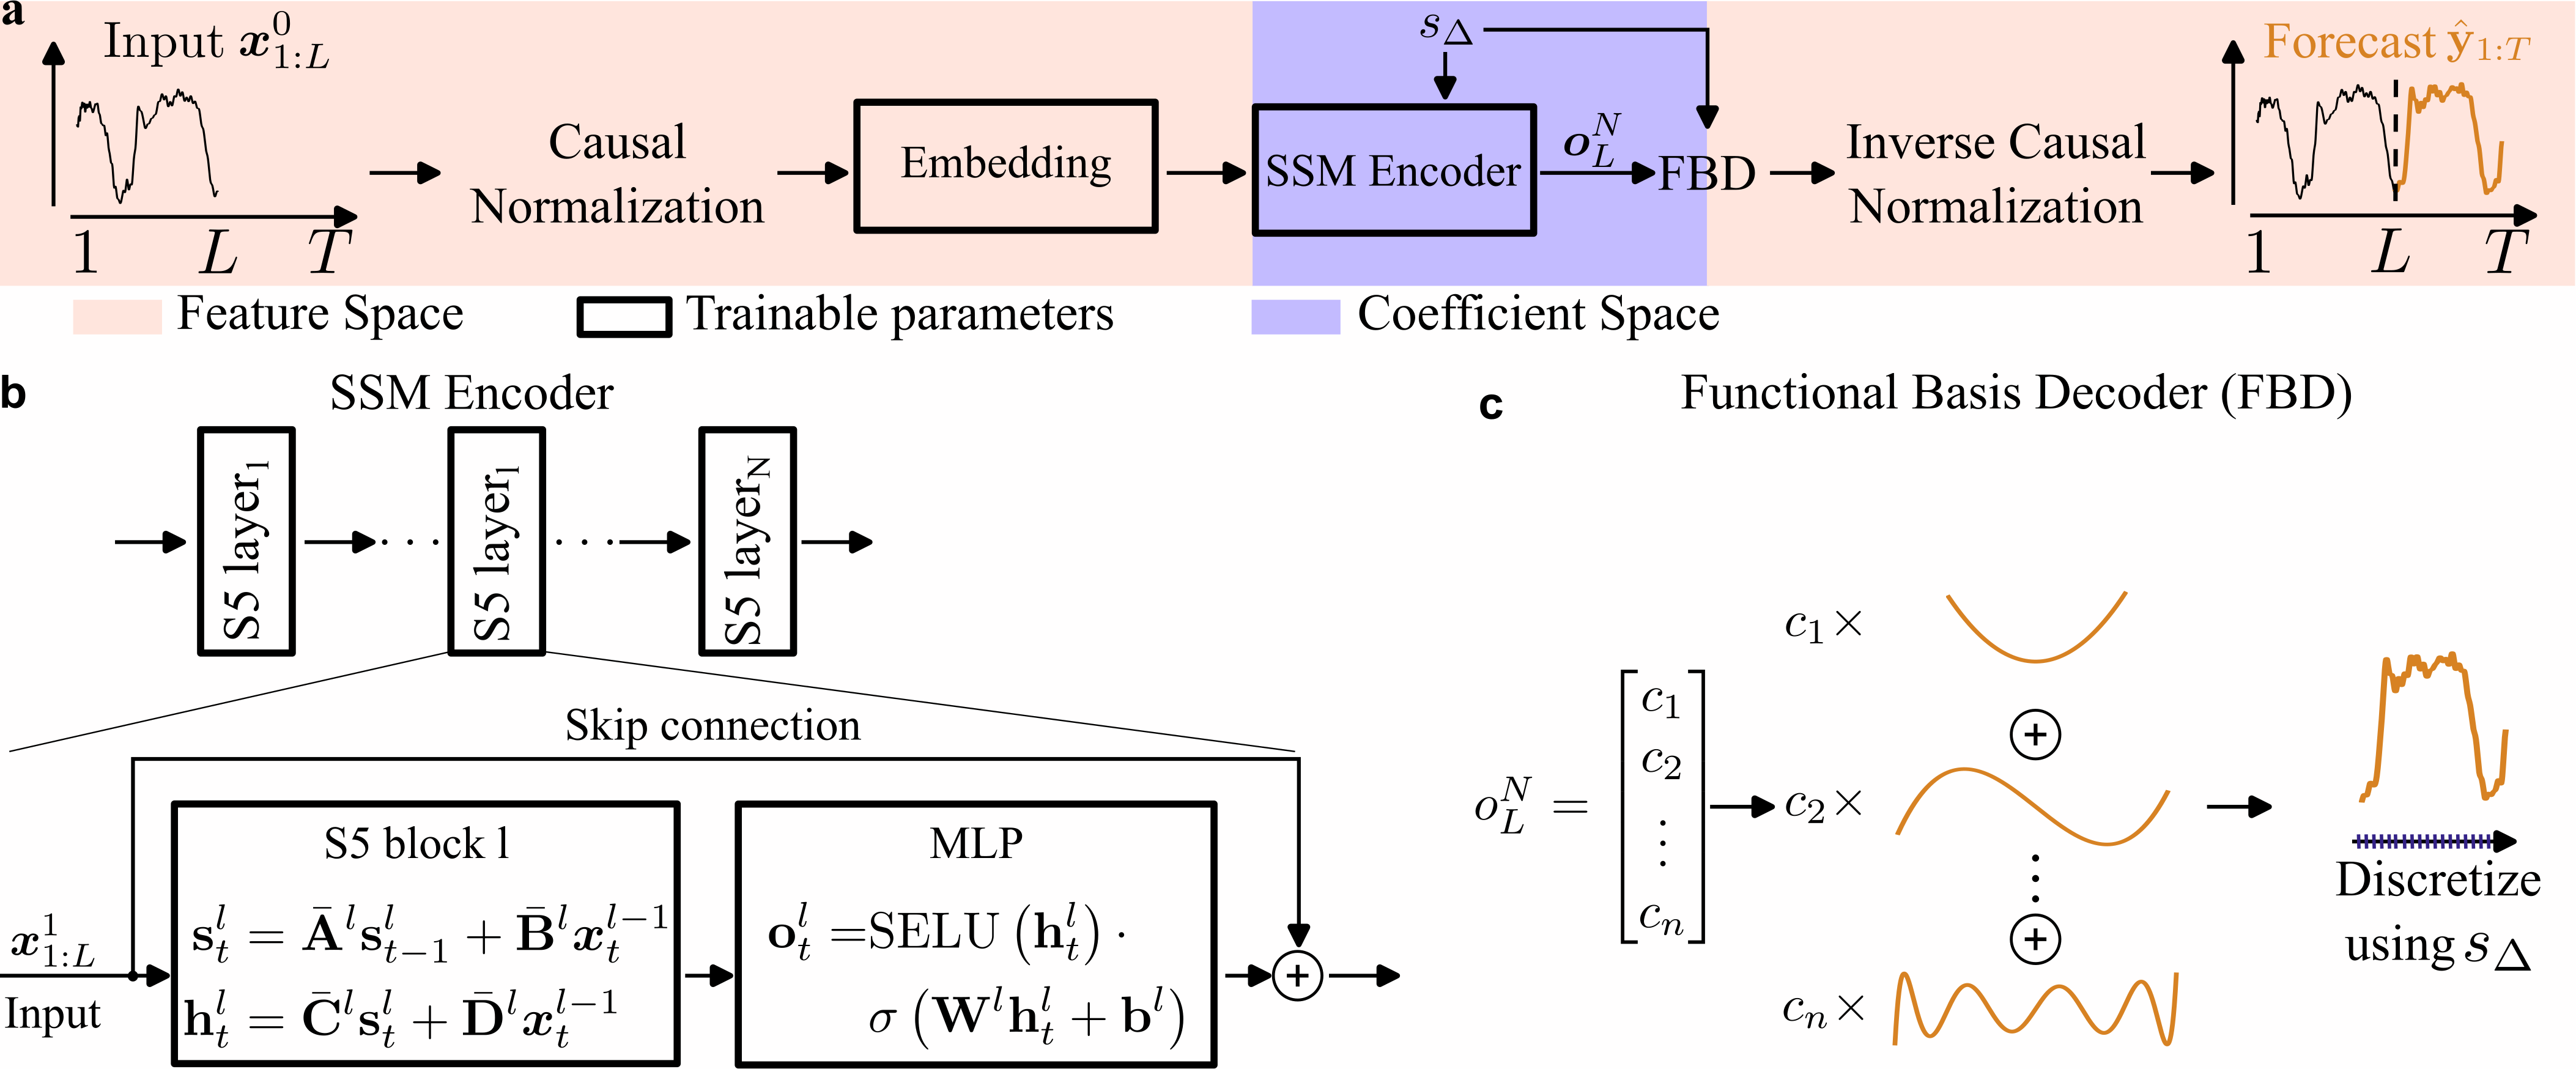

FlowState, is an encoder-decoder architecture, employing an S5-based encoder and a functional basis decoder.

Panel $\textbf{a}$ in the figure above shows an overview of its architecture. The input time series with length $L$ is first normalized in a causal manner. This causality is critical, because of the parallel forecasts FlowState carries out during training. Afterwards, the normalized inputs are embedded linearly and then provided to the SSM encoder directly without any patching. 
Importantly, while the time series before being processed by the SSM are considered to be in the feature space, where each element of the input represents features of the time series, the SSM encodes this information into a coefficient space, where it operates on coefficients of continuous basis functions.
The final output of the SSM encoder forms the basis for the Functional Basis Decoder (FBD), whose outputs are then inversely normalized, using the inverse method of the input normalization, and form the forecasts of our model. Importantly, the FBD maps from the coefficient space back to the feature space to provide the forecasts. Furthermore, the SSM encoder, as well as the FBD are controlled by an additional scaling factor $s_{\Delta}$, that allows to adjust these components to the sampling rate of the input data.

More details about the model and its components can be found in our paper:
[L. Graf, T. Ortner, S. Woźniak and A. Pantazi, "FlowState: Sampling Rate Invariant Time Series Forecasting." arXiv, 7 Aug. 2025, doi:10.48550/arXiv.2508.05287](https://www.arxiv.org/abs/2508.05287).

## Preparing the experiments

To get started, please follow the installation instructions from [here](https://github.com/ibm-granite/granite-tsfm/?tab=readme-ov-file#initial-setup).

Import the necessary third-party dependencies

In [ ]:
import warnings

import matplotlib.pyplot as plt
import torch
from huggingface_hub import hf_hub_download


warnings.filterwarnings("ignore")

Import the FlowState model

In [ ]:
from tsfm_public import FlowStateForPrediction

Prepare the configurations

In [ ]:
# Path configurations
out_dir = "./results"

# Model configurations
model_name = "ibm-granite/granite-timeseries-flowstate-r1"

# Auxiliary configurations
seed = 0
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
batch_size = 16

## Simple forecast with FlowState

Load a sample dataset from huggingface

In [ ]:
etth1_dataset = hf_hub_download(
    repo_id="hf-internal-testing/etth1-hourly-batch", filename="train-batch.pt", repo_type="dataset"
)
etth1_batch = torch.load(etth1_dataset)

Construct the model

In [ ]:
flowstate = FlowStateForPrediction.from_pretrained(model_name).to(device)

# Print the config of the model
print(flowstate.config)

# Print the model
print(flowstate)

In [ ]:
# helper function to visualize a prediction
def plot_prediction(context, target, pred):
    plt.figure(figsize=(6, 3))
    plt.plot(torch.arange(context.shape[0]), context, label="Context")
    plt.plot(torch.arange(context.shape[0], context.shape[0] + target.shape[0]), target, label="Target")
    plt.plot(torch.arange(context.shape[0], context.shape[0] + target.shape[0]), pred, label="Prediction")
    plt.xlabel("Timesteps")
    plt.legend()

In [ ]:
# Define the univariate input for FlowState
# Note, FlowState has currently only been trained with univariate data, and has never seen the ETT dataset before
context = etth1_batch["past_values"][:, :, 0:1].to(device)
target = etth1_batch["future_values"][:, :, 0:1].to(device)
print(context.shape, target.shape)

forecast = flowstate(past_values=context, prediction_length=target.shape[1], batch_first=True, scale_factor=1.0)

print(forecast.prediction_outputs.shape)  # point prediction (mean, by default)

print(
    forecast.quantile_outputs.shape
)  # probabilistic forecast (with 9 quantiles from 0.1 to 0.9 --> index 4 is the median)
plot_sample = 42
plot_prediction(
    context[plot_sample, :, 0].cpu(),
    target[plot_sample, :, 0].cpu(),
    forecast.quantile_outputs[plot_sample, 4, :, 0].detach().cpu(),
)

## Forecast with various sampling rates

In [ ]:
etth1_batch["past_values"].shape

In [ ]:
# We subsample the input, e.g., only consider every fourth step and then adjust the scaling factor accordingly.
# For example, if we subsample the data with a factor of 4, then any periodicity of the data appears four times faster.
# Hence we increase the scaling factor to four.
context_subsampled = etth1_batch["past_values"][:, ::4, 0:1].to(device)
target_subsampled = etth1_batch["future_values"][:, ::4, 0:1].to(device)

# Define the unidirectional input for FlowState
print(context_subsampled.shape)

forecast = flowstate(
    past_values=context_subsampled,
    prediction_length=target_subsampled.shape[1],
    batch_first=True,
    scale_factor=24 / 6,  # = Base Seasonality (24 timesteps) / Observed seasonality (6 timesteps)
)

print(forecast.quantile_outputs.shape)
plot_sample = 42
plot_prediction(
    context_subsampled[plot_sample, :, 0].cpu(),
    target_subsampled[plot_sample, :, 0].cpu(),
    forecast.quantile_outputs[plot_sample, 4, :, 0].detach().cpu(),
)